## Load Dataset

In [1]:
import numpy as np
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

In [2]:
# load the dataset
animes = pd.read_csv('./data/anime.csv')
ratings = pd.read_csv('./data/rating.csv')

display(animes.sample(10))

,anime_id,name,genre,type,episodes,rating,members
2339,6954,Kara no Kyoukai: Shuushou,Mystery,Special,1,7.29,45718
1957,14951,Wonderful Rush,Music,Music,1,7.40,6807
11049,34148,Nyanko Days,"Comedy, Slice of Life",TV,Unknown,NaN,1335
3998,32555,Stella no Mahou,"Comedy, School, Slice of Life",TV,12,6.83,15397
4045,3021,Yume Senshi Wingman,"Action, Comedy, Romance, School, Super Power",TV,47,6.82,918
4989,19685,Kanojo ga Flag wo Oraretara,"Comedy, Harem, Romance, School",TV,13,6.58,74634
10843,15141,Yukiwatari,Fantasy,Movie,1,6.13,130
6089,5421,Ark,"Action, Fantasy, Mecha, Military, Sci-Fi, Supe...",Movie,1,6.25,721
8328,29947,Chibikuro Sambo no Tora Taiji,Kids,Movie,1,5.80,57
2139,2803,Densetsu no Yuusha Da Garn,"Mecha, Sci-Fi, Shounen",TV,46,7.34,1897


In [3]:
display(ratings.sample(10))

,user_id,anime_id,rating
2281722,21974,18041,8
3970985,37608,15793,8
2016762,19538,18767,-1
3997211,37870,1,9
5229040,49667,1815,-1
5421892,51216,13599,-1
253233,2627,6547,10
139495,1406,299,4
838107,7673,20031,8
5370743,50813,9471,-1


# Preprocessing & Feature Engineering

In [4]:
# 사용하는 피쳐만 남김
animes = animes[['anime_id', 'type', 'rating', 'members', 'name', 'genre']]

# change column names
animes.columns = ['anime_id', 'type', 'anime_total_rating', 'members', 'name', 'genre']

# dropna
animes = animes.dropna()

animes

,anime_id,type,anime_total_rating,members,name,genre
0,32281,Movie,9.37,200630,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,5114,TV,9.26,793665,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,TV,9.25,114262,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,TV,9.17,673572,Steins;Gate,"Sci-Fi, Thriller"
4,9969,TV,9.16,151266,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
...,...,...,...,...,...,...
12289,9316,OVA,4.15,211,Toushindai My Lover: Minami tai Mecha-Minami,Hentai
12290,5543,OVA,4.28,183,Under World,Hentai
12291,5621,OVA,4.88,219,Violence Gekiga David no Hoshi,Hentai
12292,6133,OVA,4.98,175,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai


In [5]:
# 평점 테이블도 동일하게 처리, 무효한 값은 제거 (rating이 -1인 값)
ratings = ratings[['user_id', 'anime_id', 'rating']]
ratings = ratings[ratings['rating'] != -1]
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [6]:
# DataFrame join
data = ratings.merge(animes, on='anime_id', how='inner')

# 유저 정보가 없으므로, 유저의 평점 패턴에서 유저 피쳐 추출 (평균 평점 및 평점을 내린 수)
user_avg_rating = data.groupby('user_id')['rating'].mean().rename('User-AvgRating')
user_num_ratings = data.groupby('user_id')['rating'].count().rename('User-NumRatings')

# 추출한 유저 피쳐 결합
user_features = pd.concat([user_avg_rating, user_num_ratings], axis=1)

# 애니 메타 데이터에서 아이템 관련 피쳐 수가 생성
item_num_ratings = data.groupby('anime_id')['rating'].count().rename('Item-NumRatings')

# 애니 이름 피쳐에서 TF-IDF 피쳐 생성, 총 10개의 이름 생성 (most frequent 10 words)
tfidf_vectorizer = TfidfVectorizer(max_features=10)
item_name_tfidf = tfidf_vectorizer.fit_transform(animes['name']).toarray()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# 'type' 칼럼을 워핫 인코딩
# onehot_encoder = OneHotEncoder(sparse=False)      # old version
onehot_encoder = OneHotEncoder(sparse_output=True)
item_type_onehot = onehot_encoder.fit_transform(animes[['type']])

# TF-IDF 피쳐와 type 원핫 피쳐를 결합
tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id)
type_df = pd.DataFrame(item_type_onehot.toarray(), 
                       columns=[f'Type-{cat}' for cat in onehot_encoder.categories_[0]], 
                       index=animes.anime_id)

animes_features = animes[['anime_id', 'members', 'anime_total_rating']]

In [7]:
item_features = pd.DataFrame(item_num_ratings)\
    .merge(tf_idf_df, on='anime_id')\
    .merge(type_df, on='anime_id')\
    .merge(animes_features.set_index('anime_id'), on='anime_id')

In [8]:
item_features

,Item-NumRatings,chan,ga,movie,ni,no,special,specials,the,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
anime_id,,,,,,,,,,,,,,,,,,,
1,13449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82
5,5790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40
6,9385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32
7,2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36
8,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,817,5.40
34325,15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1454,7.05
34349,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1885,7.25


In [9]:
# 인터랙션 데이터와 함께 user 및 item 피쳐 결합
data = data.drop(['anime_total_rating', 'members'], axis=1)

data = data.join(user_features, on='user_id')
data = data.merge(item_features, on='anime_id')

# implicit feedback 표현을 위해 이진화 (유저의 평균 평점보다 높은 경우 1)
# 절대값으로 지정하는 방법도 있음
data['rating'] = (data['rating'] > data['User-AvgRating']).astype(int)

# Train-test split
X = data.drop(columns=['user_id', 'anime_id', 'rating', 'type', 'name', 'genre'])
y = data['rating']

X_train, X_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42)
}

In [11]:
X_train.head()

,User-AvgRating,User-NumRatings,Item-NumRatings,chan,ga,movie,ni,no,special,specials,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
1509263,7.072658,523,9122,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,359011,7.88
6271372,7.732673,101,3572,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,188685,7.78
1083815,8.152174,184,5716,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,189741,8.35
2087798,7.171598,169,6016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,194855,8.56
2273893,9.382353,34,4993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,126914,7.35


In [12]:
y_train.head()

1509263    0
6271372    1
1083815    1
2087798    0
2273893    0
Name: rating, dtype: int64

## 모델 학습

In [15]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

# dataset size
dataset_sizes = [1_100, 10_000, 100_000]

# 각 모델 별 auc score를 저장하기 위해 딕셔너리 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 딕셔너리 정의
roc_curves = {model_name: [] for model_name in models.keys()}

In [14]:
# ROC curve 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # 대각선 추가
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)

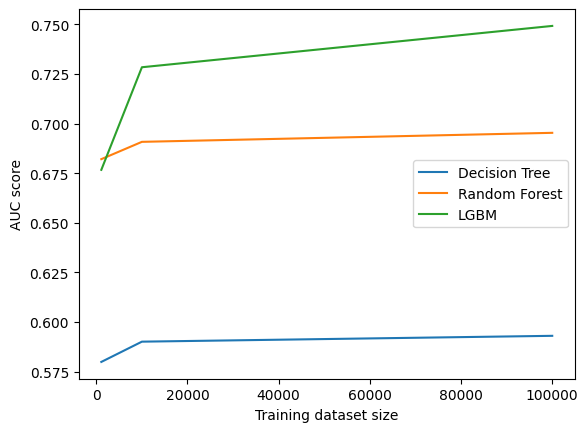

In [24]:
# AUC 스코어 시각화
for model_name, model_auc_scores in auc_scores.items():
    plt.plot(dataset_sizes, model_auc_scores, label=model_name)
plt.xlabel('Training dataset size')
plt.ylabel('AUC score')
plt.legend()
plt.show()

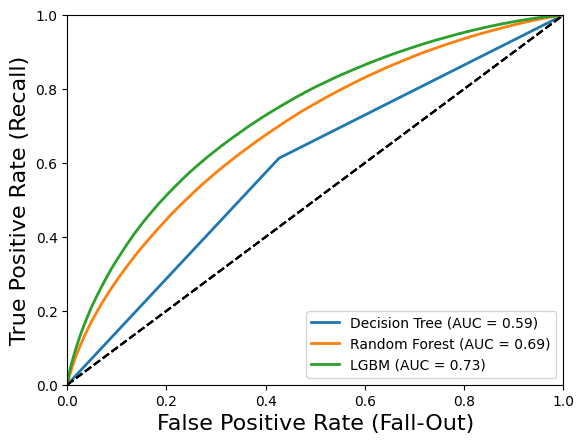

In [17]:
# 가장 큰 데이터셋에 대해서 ROC 커브 그리기
for model_name, model_roc_curves in roc_curves.items():
    fpr, tpr = model_roc_curves[-1]     # select the ROC curve for the largest dataset size
    plot_roc_curve(fpr, tpr, label=f"{model_name} (AUC = {auc_scores[model_name][-1]:.2f})")
plt.legend()
plt.show()

## 실제 예측 값 확인

In [18]:
user_id = 20

In [19]:
user_data = data[data['user_id'] == user_id]
rated_animes = user_data['anime_id'].unique()
unrated_animes = item_features[~item_features.index.isin(rated_animes)]

In [20]:
# 유저 정보 붙여주기
user_features_df = user_features.loc[user_id]
unrated_animes = unrated_animes.assign(**user_features_df)

user_features_df.head()

User-AvgRating      9.578947
User-NumRatings    19.000000
Name: 20, dtype: float64

In [21]:
unrated_animes.assign(**user_features_df)

,Item-NumRatings,chan,ga,movie,ni,no,special,specials,the,to,...,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating,User-AvgRating,User-NumRatings
anime_id,,,,,,,,,,,,,,,,,,,,,
1,13449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82,9.578947,19.0
5,5790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40,9.578947,19.0
6,9385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32,9.578947,19.0
7,2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36,9.578947,19.0
8,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06,9.578947,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,817,5.40,9.578947,19.0
34325,15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1454,7.05,9.578947,19.0
34349,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1885,7.25,9.578947,19.0


In [22]:
def recommend_top_n(user_id, model, n=5):
    # 아직 유저가 평가하지 않은 애니 가져오기
    user_data = data[data['user_id'] == user_id]
    rated_animes = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_animes)]
    
    # 유저 정보 붙여주기
    user_features_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_features_df)
    
    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]
    
    # 상위 N개의 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)
    
    return top_n_animes

In [23]:
# 특정 유저에 대한 상위 n개 예측 생성
user_id = 26
top_n = recommend_top_n(user_id, models['LGBM'], n=5)[['predicted_rating']]

# top_n개 에측의 상세 정보
top_n_details = top_n.merge(animes, how='left', left_index=True, right_on='anime_id')

print(f'Top 5 anime recommendation for user {user_id}')
display(top_n_details)

Top 5 anime recommendation for user 26


,predicted_rating,anime_id,type,anime_total_rating,members,name,genre
11998,0.180430,24743,OVA,5.76,608,Yakin Byoutou Specials,Hentai
8191,0.154807,26017,ONA,6.23,93,Backkom Specials,"Comedy, Kids, Super Power"
10809,0.141772,25749,Special,6.48,208,Yatterman Specials,"Adventure, Comedy, Parody"
10577,0.141772,25069,Special,6.16,133,Tom Sawyer no Bouken Specials,"Adventure, Drama, Historical, Slice of Life"
10602,0.141772,25079,Special,6.73,132,Trapp Ikka Monogatari Specials,"Drama, Historical, Music, Romance"


In [24]:
# 좋은 평점을 준 애니 검색
user_ratings = ratings[ratings['user_id'] == user_id]
well_rated_animes = user_ratings[user_ratings['rating'] >= user_ratings['rating'].mean()]

# 상세 정보 조회
well_rated_details = animes[animes['anime_id'].isin(well_rated_animes['anime_id'])]

# 평점 정보를 포함한 좋은 평점 정보 출력
well_rated_details = well_rated_details.merge(well_rated_animes[['anime_id', 'rating']], on='anime_id', how='inner')

In [25]:
print(f'\nWell-rated animes by user {user_id}')
display(well_rated_details)


Well-rated animes by user 26


,anime_id,type,anime_total_rating,members,name,genre,rating
0,8525,TV,7.95,284846,Kami nomi zo Shiru Sekai,"Comedy, Harem, Romance, Shounen, Supernatural",10
1,10793,TV,7.81,460959,Guilty Crown,"Action, Drama, Sci-Fi, Super Power",10


## Feature Importance plot

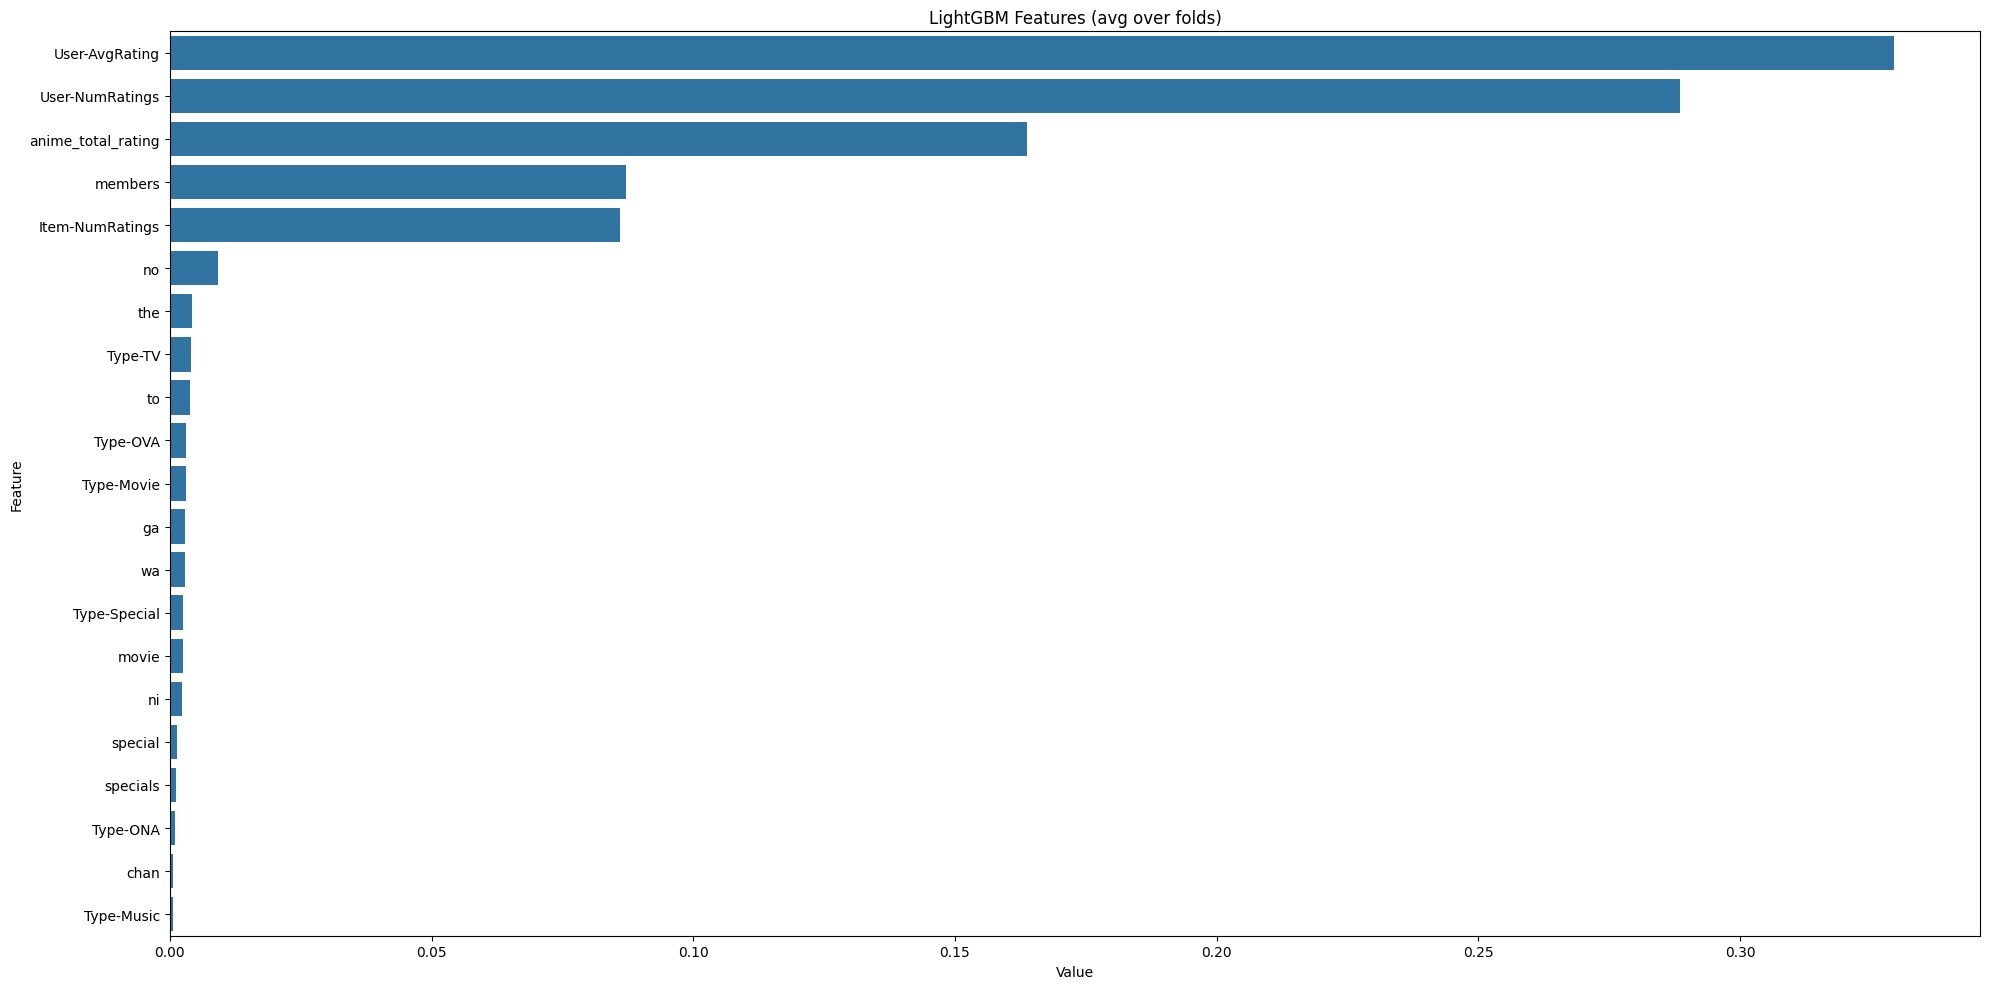

In [26]:
import matplotlib.pyplot as plt 
import seaborn as sns

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()